# Подготовка данных

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import metrics
import preprocessing.metadata_preprocessing as metadata_preprocessing

In [2]:
TRAIN_DATA_PATH = r'data/input/train.parquet'
TEST_DATA_PATH = r'data/input/test.parquet'

data_train = pd.read_parquet(TRAIN_DATA_PATH, engine="pyarrow")
data_test = pd.read_parquet(TEST_DATA_PATH, engine="pyarrow")
preprocessor = metadata_preprocessing.MultiStepPreprocessor()
X_train, X_val, y_train, y_val = preprocessor.fit_transform(data_train)
test = preprocessor.transform(data_test)

train_ids = X_train.item_id
val_ids = X_val.item_id
X_train_clean = X_train.drop('item_id', axis=1, errors='ignore')
X_val_clean = X_val.drop('item_id', axis=1, errors='ignore')


target_cols = ['real_weight', 'real_height', 'real_length', 'real_width']

Processing 250048 texts...
  Processed 10000/250048
  Processed 20000/250048
  Processed 30000/250048
  Processed 40000/250048
  Processed 50000/250048
  Processed 60000/250048
  Processed 70000/250048
  Processed 80000/250048
  Processed 90000/250048
  Processed 100000/250048
  Processed 110000/250048
  Processed 120000/250048
  Processed 130000/250048
  Processed 140000/250048
  Processed 150000/250048
  Processed 160000/250048
  Processed 170000/250048
  Processed 180000/250048
  Processed 190000/250048
  Processed 200000/250048
  Processed 210000/250048
  Processed 220000/250048
  Processed 230000/250048
  Processed 240000/250048
  Processed 250000/250048


Генерация эмбеддингов:   0%|          | 0/250048 [00:00<?, ?it/s]

Processing 62513 texts...
  Processed 10000/62513
  Processed 20000/62513
  Processed 30000/62513
  Processed 40000/62513
  Processed 50000/62513
  Processed 60000/62513


Генерация эмбеддингов:   0%|          | 0/62513 [00:00<?, ?it/s]

Processing 70274 texts...
  Processed 10000/70274
  Processed 20000/70274
  Processed 30000/70274
  Processed 40000/70274
  Processed 50000/70274
  Processed 60000/70274
  Processed 70000/70274


Генерация эмбеддингов:   0%|          | 0/70274 [00:00<?, ?it/s]

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Стандартизация
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_val_scaled = scaler.transform(X_val_clean)

y_train_np = y_train.values if isinstance(y_train, pd.DataFrame) else y_train
y_val_np = y_val.values if isinstance(y_val, pd.DataFrame) else y_val


# Определение модели, датасета и даталоадера

In [54]:
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = RegressionDataset(X_train_scaled, y_train_np)
val_dataset = RegressionDataset(X_val_scaled, y_val_np)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.3):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual  # Skip connection
        out = self.relu(out)
        return out


class ResNetMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, n_blocks=3, output_dim=4, dropout=0.3):
        super(ResNetMLP, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Residual blocks
        self.res_blocks = nn.ModuleList([
            ResidualBlock(hidden_dim, dropout) for _ in range(n_blocks)
        ])

        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.input_layer(x)
        for block in self.res_blocks:
            x = block(x)
        x = self.output_layer(x)
        return x

In [77]:
class LogMAELoss(nn.Module):
    """LOGMAE MACRO FOR LEARNING"""
    def __init__(self):
        super(LogMAELoss, self).__init__()

    def forward(self, pred, target):
        pred = torch.clamp(pred, min=0)
        target = torch.clamp(target, min=0)

        pred_log = torch.log1p(pred)
        target_log = torch.log1p(target)


        mae = torch.abs(pred_log - target_log)
        return mae.mean()


# Обучение модели

In [96]:
input_dim = X_train_scaled.shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model_mlp = ResNetMLP(input_dim=input_dim, hidden_dim=512, n_blocks=4, dropout=0.5)
model_mlp = model_mlp.to(device)

# Loss and optimizer
criterion = LogMAELoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

num_epochs = 50
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):

    model_mlp.train()
    epoch_train_losses = []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model_mlp(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())

    train_losses.append(np.mean(epoch_train_losses))

    # validation
    model_mlp.eval()
    epoch_val_losses = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model_mlp(X_batch)
            loss = criterion(outputs, y_batch)
            epoch_val_losses.append(loss.item())

    val_losses.append(np.mean(epoch_val_losses))
    scheduler.step(val_losses[-1])

    # Сохранение лучшей модели
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_epoch = epoch
        torch.save(model_mlp.state_dict(), 'best_model.pth')
        print(f'epoch {epoch+1}: train loss {train_losses[-1]:.3f}  val loss {val_losses[-1]:.3f} BEST')
    else:
        print(f'epoch {epoch+1}: train loss {train_losses[-1]:.3f}  val loss {val_losses[-1]:.3f}')

print(f'\nBest model saved at epoch {best_epoch+1} with val loss {best_val_loss:.3f}')

Using device: cuda
epoch 1: train loss 0.366  val loss 0.342 BEST
epoch 2: train loss 0.345  val loss 0.337 BEST
epoch 3: train loss 0.341  val loss 0.337 BEST
epoch 4: train loss 0.339  val loss 0.334 BEST
epoch 5: train loss 0.337  val loss 0.333 BEST
epoch 6: train loss 0.336  val loss 0.333
epoch 7: train loss 0.335  val loss 0.332 BEST
epoch 8: train loss 0.335  val loss 0.333
epoch 9: train loss 0.334  val loss 0.332
epoch 10: train loss 0.334  val loss 0.333
epoch 11: train loss 0.333  val loss 0.332
epoch 12: train loss 0.333  val loss 0.332 BEST
epoch 13: train loss 0.333  val loss 0.332
epoch 14: train loss 0.332  val loss 0.333
epoch 15: train loss 0.332  val loss 0.331 BEST
epoch 16: train loss 0.332  val loss 0.331
epoch 17: train loss 0.332  val loss 0.332
epoch 18: train loss 0.332  val loss 0.332
epoch 19: train loss 0.331  val loss 0.331
epoch 20: train loss 0.331  val loss 0.332
epoch 21: train loss 0.331  val loss 0.331
epoch 22: train loss 0.327  val loss 0.329 BEST

## Визуализация

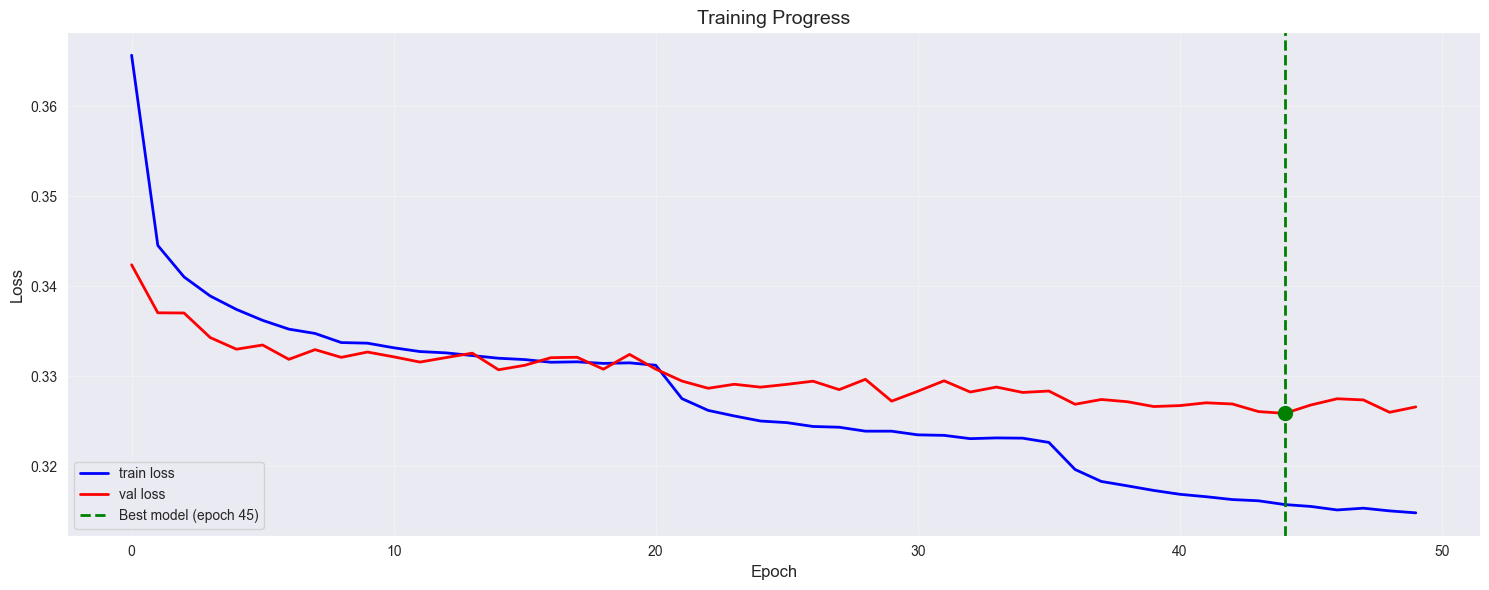

In [97]:
f, ax = plt.subplots(figsize=(15, 6))

ax.plot(train_losses, 'b-', label='train loss', linewidth=2)
ax.plot(val_losses, 'r-', label='val loss', linewidth=2)

ax.axvline(x=best_epoch, color='green', linestyle='--', linewidth=2,
           label=f'Best model (epoch {best_epoch+1})')

ax.scatter(best_epoch, val_losses[best_epoch], color='green', s=100, zorder=5)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Progress', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [98]:
val_answers = []
model_mlp.eval()

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        output = model_mlp(X_batch)
        val_answers.append(output.cpu().numpy())

val_answers = np.concatenate(val_answers, axis=0)

In [110]:
print(f'macro logmae {metrics.logmae_macro(y_val_np, val_answers)}')
print(f'by cat logmae {metrics.logmae_bycat(y_val_np, val_answers)}')

macro logmae 0.3265637808169848
by cat logmae [0.24915685 0.48759877 0.27872455 0.29077496]


# Результаты на тесте

In [43]:
test_ids = test['item_id'].values
X_test_clean = test.drop('item_id', axis=1, errors='ignore')

test_scaled = scaler.transform(X_test_clean)

In [105]:
test_dataset = RegressionDataset(test_scaled, np.zeros((len(test_scaled), 4)))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_mlp.eval()
test_predictions = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        output = model_mlp(X_batch)
        test_predictions.append(output.cpu().numpy())

test_predictions = np.concatenate(test_predictions, axis=0)

test_predictions = np.maximum(0, test_predictions)

print(f"Test predictions shape: {test_predictions.shape}")

Test predictions shape: (70274, 4)


In [106]:
submission = pd.DataFrame(
    test_predictions,
    columns=['weight', 'height', 'length', 'width']
)

submission.insert(0, 'item_id', test_ids)

In [107]:
submission.to_csv('data/output/solution_MLP.csv', index=False)
# 0.3168